In [38]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
# descarga la dataset
import kagglehub
path = kagglehub.dataset_download("yasserh/titanic-dataset")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'titanic-dataset' dataset.
Path to dataset files: /kaggle/input/titanic-dataset


In [40]:
df = pd.read_csv("/kaggle/input/titanic-dataset/Titanic-Dataset.csv")

print(df.shape)
print(df.head(10))
df.info()
print(df.describe(include="all"))

(891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J  

/tmp/ipython-input-3296168478.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Survived", data=df, palette="Set2")


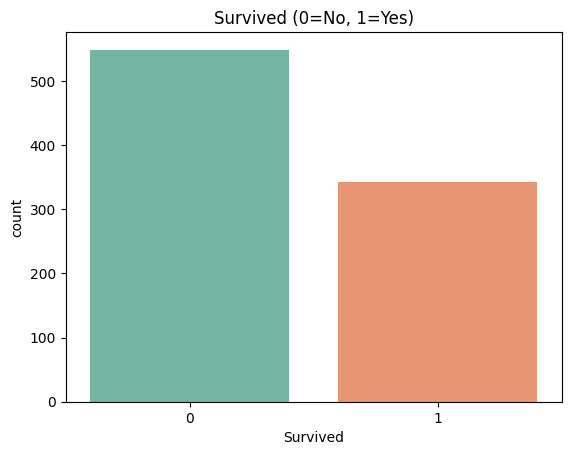

In [41]:
# balance del target
sns.countplot(x="Survived", data=df, palette="Set2")
plt.title("Survived (0=No, 1=Yes)")
plt.show()

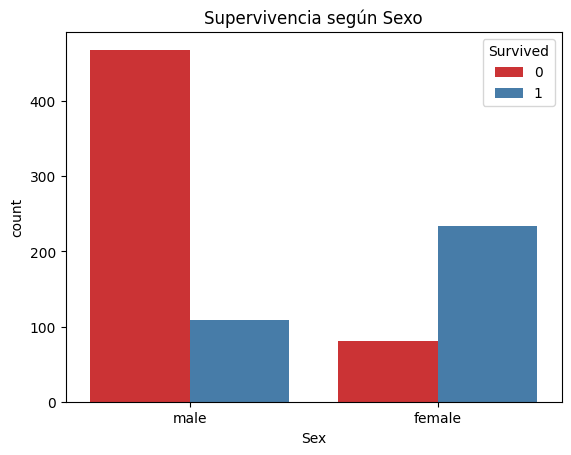

In [42]:
# relación clave: sexo vs supervivencia
sns.countplot(x="Sex", hue="Survived", data=df, palette="Set1")
plt.title("Supervivencia según Sexo")
plt.show()

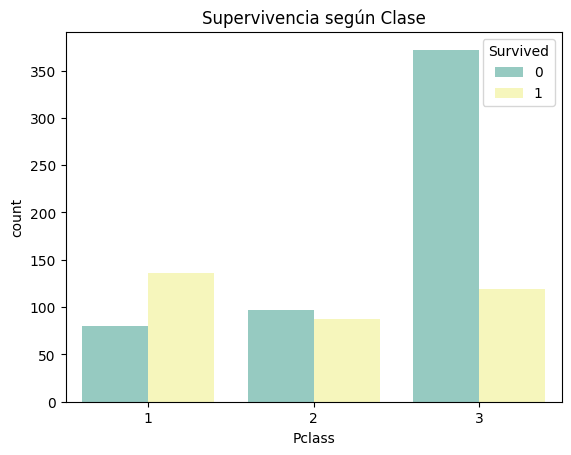

In [43]:
# relación clave: clase vs supervivencia
sns.countplot(x="Pclass", hue="Survived", data=df, palette="Set3")
plt.title("Supervivencia según Clase")
plt.show()

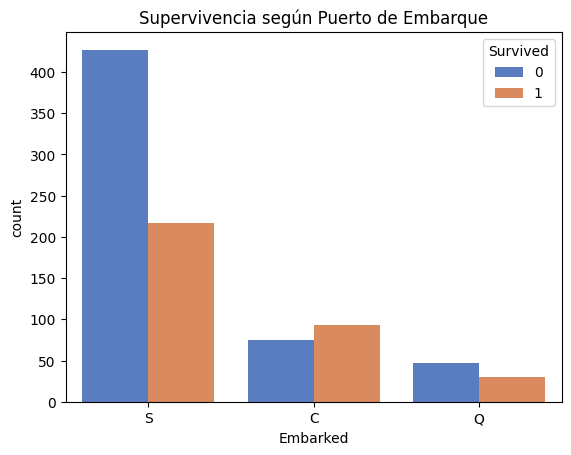

In [44]:
# relación útil: puerto de embarque vs supervivencia
sns.countplot(x="Embarked", hue="Survived", data=df, palette="muted")
plt.title("Supervivencia según Puerto de Embarque")
plt.show()

/tmp/ipython-input-3547084641.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df["Survived"]==1]["Age"].dropna(), shade=True, label="Sobrevivió", color="green")
/tmp/ipython-input-3547084641.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df["Survived"]==0]["Age"].dropna(), shade=True, label="No sobrevivió", color="red")


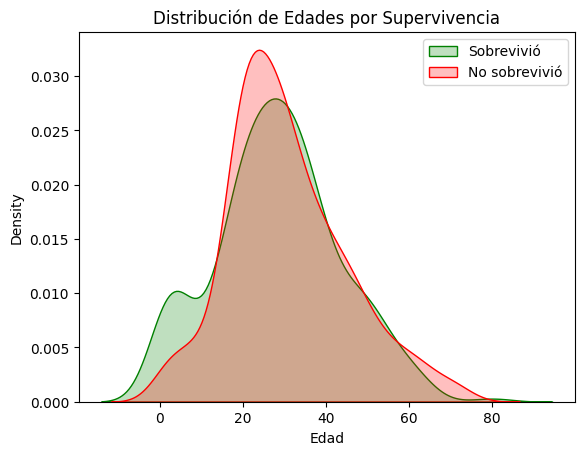

In [45]:
# distribución de edades separada por supervivencia
sns.kdeplot(data=df[df["Survived"]==1]["Age"].dropna(), shade=True, label="Sobrevivió", color="green")
sns.kdeplot(data=df[df["Survived"]==0]["Age"].dropna(), shade=True, label="No sobrevivió", color="red")
plt.title("Distribución de Edades por Supervivencia")
plt.xlabel("Edad")
plt.legend()
plt.show()

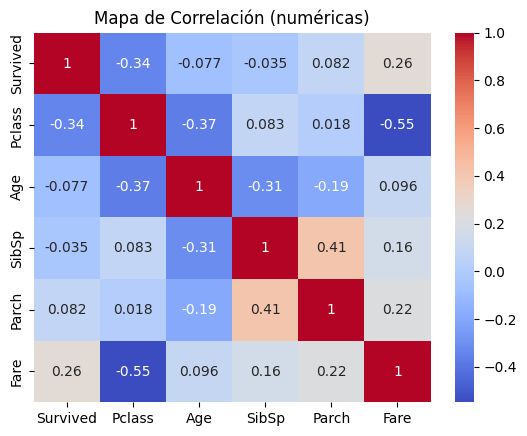

In [46]:
# correlación entre numéricas
sns.heatmap(df[["Survived","Pclass","Age","SibSp","Parch","Fare"]].corr(), annot=True, cmap="coolwarm")
plt.title("Mapa de Correlación (numéricas)")
plt.show()

In [47]:
# tasas de supervivencia por grupo
df[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [48]:
df[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [49]:
df[["SibSp", "Survived"]].groupby(["SibSp"], as_index=False).mean().sort_values("Survived", ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [50]:
df[["Parch", "Survived"]].groupby(["Parch"], as_index=False).mean().sort_values("Survived", ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [51]:
!pip -q install deap scikit-optimize

In [52]:
import pandas as pd
import numpy as np
import time, random

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint, uniform

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from deap import base, creator, tools
import matplotlib.pyplot as plt


In [53]:
# 1. Features y target
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target = "Survived"

X = df[features]
y = df[target]

numeric_features = ["Age", "SibSp", "Parch", "Fare"]
categorical_features = ["Pclass", "Sex", "Embarked"]


# Numéricas: imputar mediana + escalar
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
# Categóricas: imputar moda + OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number', 'bool']).columns.tolist()

pre = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

pipe = Pipeline([
    ("pre", pre),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# HYPERBAND

In [54]:
param_dist = {
    "rf__max_depth": randint(3, 20),
    "rf__min_samples_split": randint(2, 20),
    "rf__max_features": uniform(0.3, 0.7),
}

hb = HalvingRandomSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    factor=3,
    resource="rf__n_estimators",
    min_resources=20,
    max_resources=300,
    scoring="f1",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

tic = time.time()
hb.fit(X_train, y_train)
hb_time = time.time() - tic

hb_best = hb.best_estimator_
t0 = time.time(); hb_best.fit(X_train, y_train); hb_train_time = time.time() - t0

yph = hb_best.predict(X_holdout)
probh = hb_best.predict_proba(X_holdout)[:, 1]

hb_acc = accuracy_score(y_holdout, yph)
hb_f1  = f1_score(y_holdout, yph)
hb_auc = roc_auc_score(y_holdout, probh)

hb_evals = len(hb.cv_results_["params"])
hb_std   = float(hb.cv_results_["std_test_score"][hb.best_index_])

print("Best params:", hb.best_params_)
print(f"CV F1 mean: {hb.best_score_:.4f} | CV F1 std: {hb_std:.4f}")
print(f"Holdout -> Acc {hb_acc:.4f} | F1 {hb_f1:.4f} | AUC {hb_auc:.4f}")
print(f"Tiempos -> Búsqueda {hb_time:.2f}s | Entrenamiento final {hb_train_time:.2f}s")
print("Evaluaciones:", hb_evals)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 300
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 15
n_resources: 20
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 1
n_candidates: 5
n_resources: 60
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'rf__max_depth': 17, 'rf__max_features': np.float64(0.7782844631778207), 'rf__min_samples_split': 13, 'rf__n_estimators': 180}
CV F1 mean: 0.7653 | CV F1 std: 0.0457
Holdout -> Acc 0.7877 | F1 0.7031 | AUC 0.8300
Tiempos -> Búsqueda 34.67s | Entrenamiento final 0.50s
Evaluaciones: 22


# GENETIC ALGORITHM (DEAP)

In [55]:
if not hasattr(creator, "FitnessMax"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMax)

N_ESTIMATORS_MIN, N_ESTIMATORS_MAX = 50, 300
MAX_DEPTH_MIN,  MAX_DEPTH_MAX      = 3, 20
MIN_SPLIT_MIN,  MIN_SPLIT_MAX      = 2, 20
MAX_FEATURES_CHOICES = ["sqrt", "log2"]

toolbox = base.Toolbox()
toolbox.register("n_estimators", random.randint, N_ESTIMATORS_MIN, N_ESTIMATORS_MAX)
toolbox.register("max_depth", random.randint, MAX_DEPTH_MIN, MAX_DEPTH_MAX)
toolbox.register("min_samples_split", random.randint, MIN_SPLIT_MIN, MIN_SPLIT_MAX)
toolbox.register("max_features_idx", random.randint, 0, len(MAX_FEATURES_CHOICES)-1)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.n_estimators, toolbox.max_depth,
                  toolbox.min_samples_split, toolbox.max_features_idx), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    n_estimators, max_depth, min_split, mf_idx = individual
    model = Pipeline(steps=[
        ("pre", pre),
        ("rf", RandomForestClassifier(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            min_samples_split=int(min_split),
            max_features=MAX_FEATURES_CHOICES[int(mf_idx)],
            random_state=42,
            n_jobs=-1
        ))
    ])
    scores = cross_val_score(model, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)
    return (float(np.mean(scores)),)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)

def mutate(ind, indpb=0.25):
    if random.random() < indpb:
        ind[0] = random.randint(N_ESTIMATORS_MIN, N_ESTIMATORS_MAX)
    if random.random() < indpb:
        ind[1] = random.randint(MAX_DEPTH_MIN, MAX_DEPTH_MAX)
    if random.random() < indpb:
        ind[2] = random.randint(MIN_SPLIT_MIN, MIN_SPLIT_MAX)
    if random.random() < indpb:
        ind[3] = random.randint(0, len(MAX_FEATURES_CHOICES)-1)
    return (ind,)

toolbox.register("mutate", mutate, indpb=0.25)
toolbox.register("select", tools.selTournament, tournsize=3)

random.seed(42)
POP_SIZE, N_GEN = 24, 10
CX_PROB, MUT_PROB = 0.8, 0.2

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean); stats.register("std", np.std)
stats.register("min", np.min);  stats.register("max", np.max)

eval_counter = 0
def eval_count(ind):
    global eval_counter; eval_counter += 1
    return evaluate(ind)

toolbox.unregister("evaluate")
toolbox.register("evaluate", eval_count)

tic = time.time()
# gen 0
fits = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fits):
    ind.fitness.values = fit
hof.update(pop)
# evolución
for _ in range(1, N_GEN + 1):
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))
    for c1, c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CX_PROB:
            toolbox.mate(c1, c2)
            try: del c1.fitness.values; del c2.fitness.values
            except Exception: pass
    for mut in offspring:
        if random.random() < MUT_PROB:
            toolbox.mutate(mut)
            try: del mut.fitness.values
            except Exception: pass
    invalid = [ind for ind in offspring if not ind.fitness.valid]
    fits = map(toolbox.evaluate, invalid)
    for ind, fit in zip(invalid, fits):
        ind.fitness.values = fit
    pop[:] = offspring
    hof.update(pop)
ga_time = time.time() - tic

best_ind = hof[0]
ga_params = {
    "n_estimators": int(best_ind[0]),
    "max_depth": int(best_ind[1]),
    "min_samples_split": int(best_ind[2]),
    "max_features": MAX_FEATURES_CHOICES[int(best_ind[3])]
}

ga_model = Pipeline(steps=[
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=ga_params["n_estimators"],
        max_depth=ga_params["max_depth"],
        min_samples_split=ga_params["min_samples_split"],
        max_features=ga_params["max_features"],
        random_state=42,
        n_jobs=-1
    ))
])

t0 = time.time(); ga_model.fit(X_train, y_train); ga_train_time = time.time() - t0
yg = ga_model.predict(X_holdout)
probg = ga_model.predict_proba(X_holdout)[:, 1]

ga_acc = accuracy_score(y_holdout, yg)
ga_f1  = f1_score(y_holdout, yg)
ga_auc = roc_auc_score(y_holdout, probg)

# estabilidad GA = std CV del mejor
ga_cv_scores = cross_val_score(ga_model, X_train, y_train, scoring="f1", cv=cv, n_jobs=-1)
ga_std = float(np.std(ga_cv_scores))

print("Best params:", ga_params)
print(f"CV F1 mean: {np.mean(ga_cv_scores):.4f} | CV F1 std: {ga_std:.4f}")
print(f"Holdout -> Acc {ga_acc:.4f} | F1 {ga_f1:.4f} | AUC {ga_auc:.4f}")
print(f"Tiempos -> Búsqueda {ga_time:.2f}s | Entrenamiento final {ga_train_time:.2f}s")
print("Evaluaciones:", eval_counter)

Best params: {'n_estimators': 230, 'max_depth': 5, 'min_samples_split': 3, 'max_features': 'sqrt'}
CV F1 mean: 0.7510 | CV F1 std: 0.0346
Holdout -> Acc 0.8101 | F1 0.7069 | AUC 0.8434
Tiempos -> Búsqueda 635.97s | Entrenamiento final 0.56s
Evaluaciones: 215


# BAYESIAN OPTIMIZATION

In [56]:
search_spaces = {
    "rf__n_estimators": Integer(50, 300),
    "rf__max_depth": Integer(3, 20),
    "rf__min_samples_split": Integer(2, 20),
    "rf__max_features": Real(0.3, 1.0),
}

bayes = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_spaces,
    n_iter=32,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

tic = time.time()
bayes.fit(X_train, y_train)
bayes_time = time.time() - tic

bayes_best = bayes.best_estimator_
t0 = time.time(); bayes_best.fit(X_train, y_train); bayes_train_time = time.time() - t0

yb = bayes_best.predict(X_holdout)
probb = bayes_best.predict_proba(X_holdout)[:, 1]

b_acc = accuracy_score(y_holdout, yb)
b_f1  = f1_score(y_holdout, yb)
b_auc = roc_auc_score(y_holdout, probb)

b_evals = len(bayes.cv_results_["params"])
b_std   = float(bayes.cv_results_["std_test_score"][bayes.best_index_])

print("Best params:", bayes.best_params_)
print(f"CV F1 mean: {bayes.best_score_:.4f} | CV F1 std: {b_std:.4f}")
print(f"Holdout -> Acc {b_acc:.4f} | F1 {b_f1:.4f} | AUC {b_auc:.4f}")
print(f"Tiempos -> Búsqueda {bayes_time:.2f}s | Entrenamiento final {bayes_train_time:.2f}s")
print("Evaluaciones:", b_evals)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

# TABLA COMPARATIVA

In [57]:
comparison_df = pd.DataFrame([
    {
        "Method": "Hyperband",
        "Accuracy": hb_acc, "F1": hb_f1, "AUC": hb_auc,
        "Search Time (s)": hb_time, "Final Train Time (s)": hb_train_time,
        "Number of Evaluations": hb_evals, "Stability (F1 std)": hb_std
    },
    {
        "Method": "Bayesian Optimization",
        "Accuracy": b_acc, "F1": b_f1, "AUC": b_auc,
        "Search Time (s)": bayes_time, "Final Train Time (s)": bayes_train_time,
        "Number of Evaluations": b_evals, "Stability (F1 std)": b_std
    },
    {
        "Method": "Genetic Algorithm (DEAP)",
        "Accuracy": ga_acc, "F1": ga_f1, "AUC": ga_auc,
        "Search Time (s)": ga_time, "Final Train Time (s)": ga_train_time,
        "Number of Evaluations": eval_counter, "Stability (F1 std)": ga_std
    }
])

print(comparison_df.to_string(index=False))


                  Method  Accuracy       F1      AUC  Search Time (s)  Final Train Time (s)  Number of Evaluations  Stability (F1 std)
               Hyperband  0.787709 0.703125 0.830040        34.674208              0.499882                     22            0.045657
   Bayesian Optimization  0.798883 0.714286 0.826877       121.479530              0.556720                     32            0.019459
Genetic Algorithm (DEAP)  0.810056 0.706897 0.843412       635.966301              0.557557                    215            0.034571


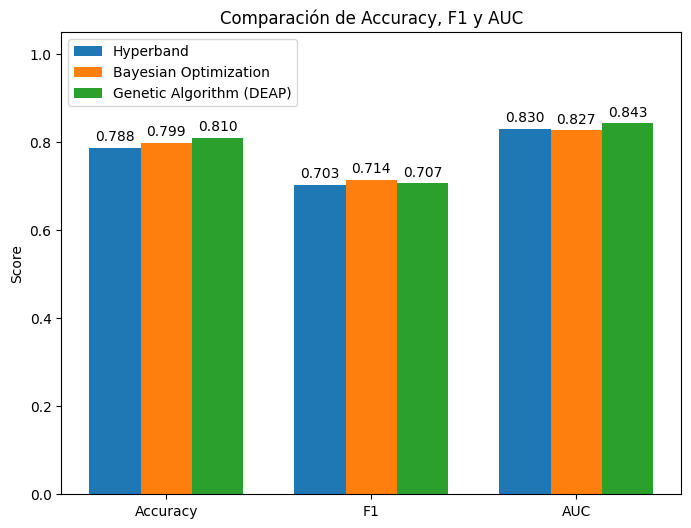

In [58]:
metrics = ["Accuracy", "F1", "AUC"]
methods = comparison_df["Method"].tolist()
scores = [[comparison_df.loc[i, m] for m in metrics] for i in range(len(comparison_df))]

x = np.arange(len(metrics)); width = 0.25
fig, ax = plt.subplots(figsize=(8,6))
for i, method in enumerate(methods):
    bars = ax.bar(x + i*width - width, scores[i], width, label=method)
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f"{h:.3f}", xy=(bar.get_x()+bar.get_width()/2, h),
                    xytext=(0,3), textcoords="offset points",
                    ha="center", va="bottom")
ax.set_ylabel("Score"); ax.set_title("Comparación de Accuracy, F1 y AUC")
ax.set_xticks(x); ax.set_xticklabels(metrics); ax.set_ylim(0, 1.05); ax.legend()
plt.show()


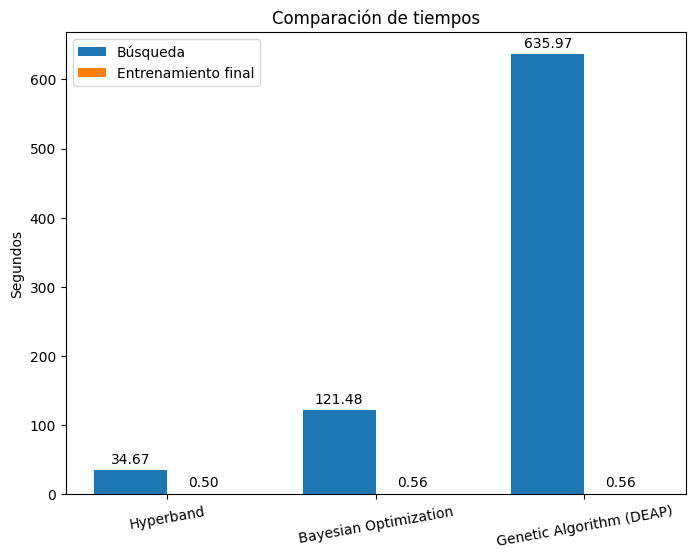

In [59]:
x = np.arange(len(methods)); width = 0.35
fig, ax = plt.subplots(figsize=(8,6))
bars1 = ax.bar(x - width/2, comparison_df["Search Time (s)"], width, label="Búsqueda")
bars2 = ax.bar(x + width/2, comparison_df["Final Train Time (s)"], width, label="Entrenamiento final")
ax.set_ylabel("Segundos"); ax.set_title("Comparación de tiempos"); ax.set_xticks(x); ax.set_xticklabels(methods, rotation=10); ax.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f"{h:.2f}", xy=(bar.get_x()+bar.get_width()/2, h),
                    xytext=(0,3), textcoords="offset points",
                    ha="center", va="bottom")
plt.show()

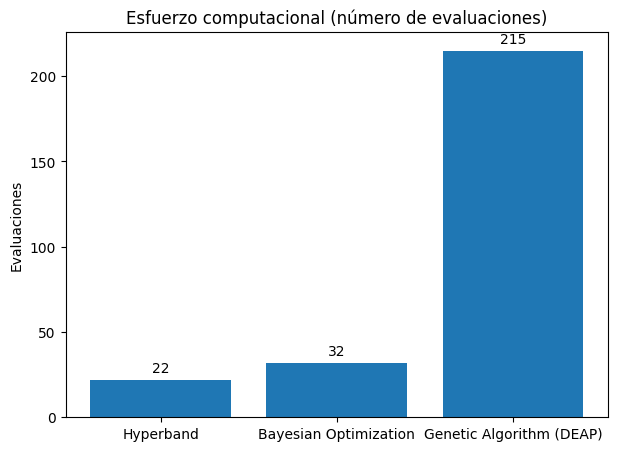

In [60]:
fig, ax = plt.subplots(figsize=(7,5))
bars = ax.bar(methods, comparison_df["Number of Evaluations"])
ax.set_ylabel("Evaluaciones"); ax.set_title("Esfuerzo computacional (número de evaluaciones)")
for bar in bars:
    h = bar.get_height()
    ax.annotate(f"{int(h)}", xy=(bar.get_x()+bar.get_width()/2, h),
                xytext=(0,3), textcoords="offset points",
                ha="center", va="bottom")
plt.show()
